# Stock market predictions - Decision Trees and Random Forests

Welcome to my rather scuffed implementation of the Decision Tree and Random Forest algorithms for stock market predictions.

The data used in this notebook is sourced from [this Kaggle dataset](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs). Data from the GE stock ticker is used in specific, which can be found in the file "ge.us.txt" in CSV format. The dataset includes OHLC prices and the volume, all in 1-day intervals.

## Goals

The project's goal is to use the models above to predict the closing prices of a certain stock ticker. Namely, given the closing prices of a stock over n days, we want to predict the closing prices of the stocks over the next m days.

# Data preprocessing

## Importing modules

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import seaborn as sns
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression

## Reading file

In [3]:
df = ''
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        df = pd.read_csv(os.path.join(dirname, filename))

df.drop('OpenInt', axis=1, inplace=True)

df0 = df['Close']
df = pd.DataFrame(df0)

print(df)

data\ge.us.txt
         Close
0       0.6201
1       0.6201
2       0.6122
3       0.5957
4       0.5957
...        ...
14053  20.1300
14054  20.2100
14055  20.1200
14056  19.9900
14057  20.4900

[14058 rows x 1 columns]


# Preprocessing steps

In [4]:
print(df)
df.describe()

# plt.figure(figsize = (10 , 5))
# sns.lineplot(df , x = df.index , y = 'Close')


         Close
0       0.6201
1       0.6201
2       0.6122
3       0.5957
4       0.5957
...        ...
14053  20.1300
14054  20.2100
14055  20.1200
14056  19.9900
14057  20.4900

[14058 rows x 1 columns]


,Close
count,14058.000000
mean,10.534161
std,11.743726
min,0.459020
25%,0.901500
50%,3.884800
75%,21.370000
max,48.056000


Splitting sets

In [5]:

pred = 100

df['Prediction'] = df['Close'].shift(-pred)
df.tail()

X = np.array(df.drop(['Prediction'], axis=1))[:-pred]
print(X)

y = np.array(df['Prediction'])[:-pred]
print(y)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)



x_future = df.drop(['Prediction'], axis=1)[:-pred]
x_future = x_future.tail(pred)
x_future = np.array(x_future)

[[ 0.6201]
 [ 0.6201]
 [ 0.6122]
 ...
 [28.515 ]
 [27.852 ]
 [27.505 ]]
[ 0.5634  0.5476  0.5233 ... 20.12   19.99   20.49  ]


DT

[27.277      27.0545     25.9265     26.941      27.0545     26.753
 26.743      27.178      28.20083333 26.05       25.891      25.782
 26.119      29.08375    27.52       28.0045     26.555      25.279
 25.183      26.426      25.654      25.183      25.183      25.337
 24.51       25.391      24.753      25.188      28.0045     25.391
 25.525      28.713      28.762      24.758      28.158      24.951
 27.783      24.599      24.852      29.543      24.599      24.248
 24.357      24.753      24.758      25.279      24.228      28.69833333
 24.04       24.307      25.782      27.505      24.673      23.782
 23.584      24.51       23.673      23.9455     23.9455     23.93
 24.46       24.2        26.95225    22.385      26.95225    25.11
 27.5115     24.37       29.0975     24.18       27.8885     24.8
 28.46866667 24.54       24.39       23.43       23.36       23.07
 24.54       22.98       24.5275     23.19       23.12       27.981
 23.83       22.32       21.89       21.5       

C:\Users\Admin\AppData\Local\Temp\ipykernel_19224\1482096151.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


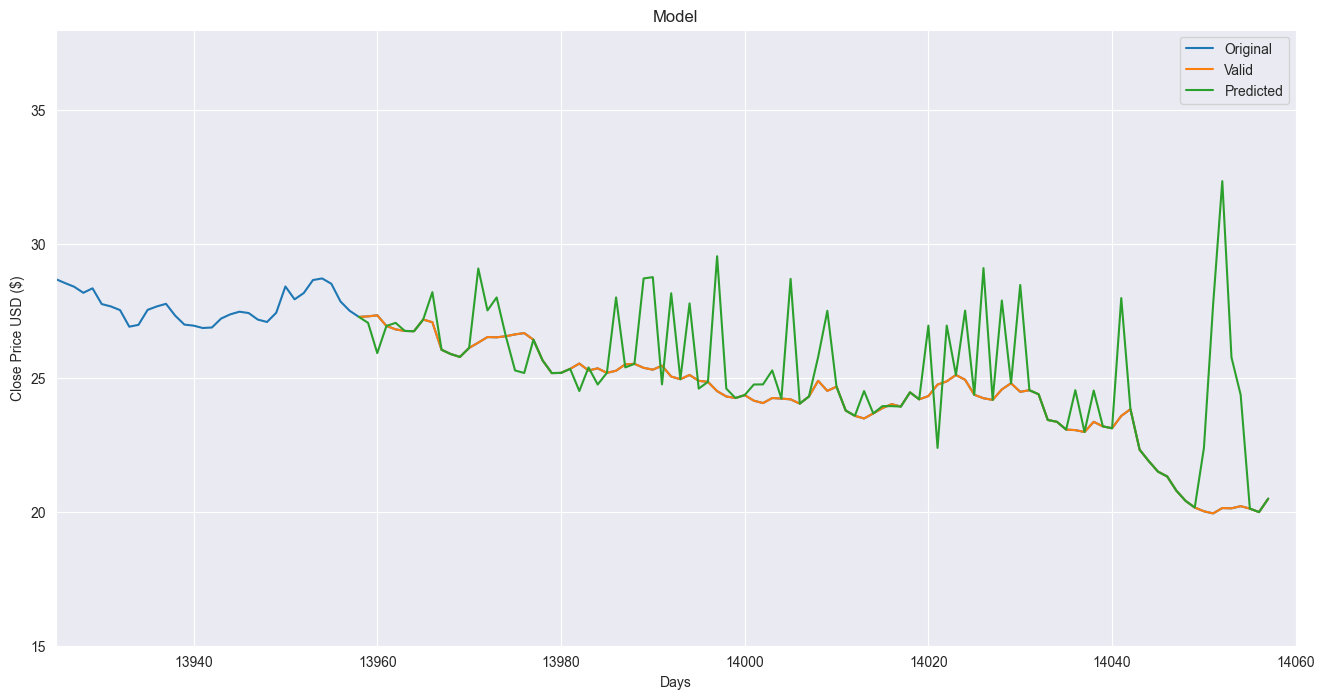

MSE = 16.58171676243056


[Text(0.5, 0.9166666666666666, 'x[0] <= 11.525\nsquared_error = 137.872\nsamples = 11166\nvalue = 10.601'),
 Text(0.25, 0.75, 'x[0] <= 4.907\nsquared_error = 7.992\nsamples = 7112\nvalue = 2.573'),
 Text(0.125, 0.5833333333333334, 'x[0] <= 2.162\nsquared_error = 1.395\nsamples = 5966\nvalue = 1.526'),
 Text(0.0625, 0.4166666666666667, 'x[0] <= 1.236\nsquared_error = 0.169\nsamples = 4786\nvalue = 0.999'),
 Text(0.03125, 0.25, 'x[0] <= 0.946\nsquared_error = 0.03\nsamples = 4141\nvalue = 0.853'),
 Text(0.015625, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.046875, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.09375, 0.25, 'x[0] <= 1.896\nsquared_error = 0.048\nsamples = 645\nvalue = 1.935'),
 Text(0.078125, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.109375, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.1875, 0.4166666666666667, 'x[0] <= 3.176\nsquared_error = 0.666\nsamples = 1180\nvalue = 3.665'),
 Text(0.15625, 0.25, 'x[0] <= 2.959\nsquared_error = 0.158\nsamples = 533\nvalue 

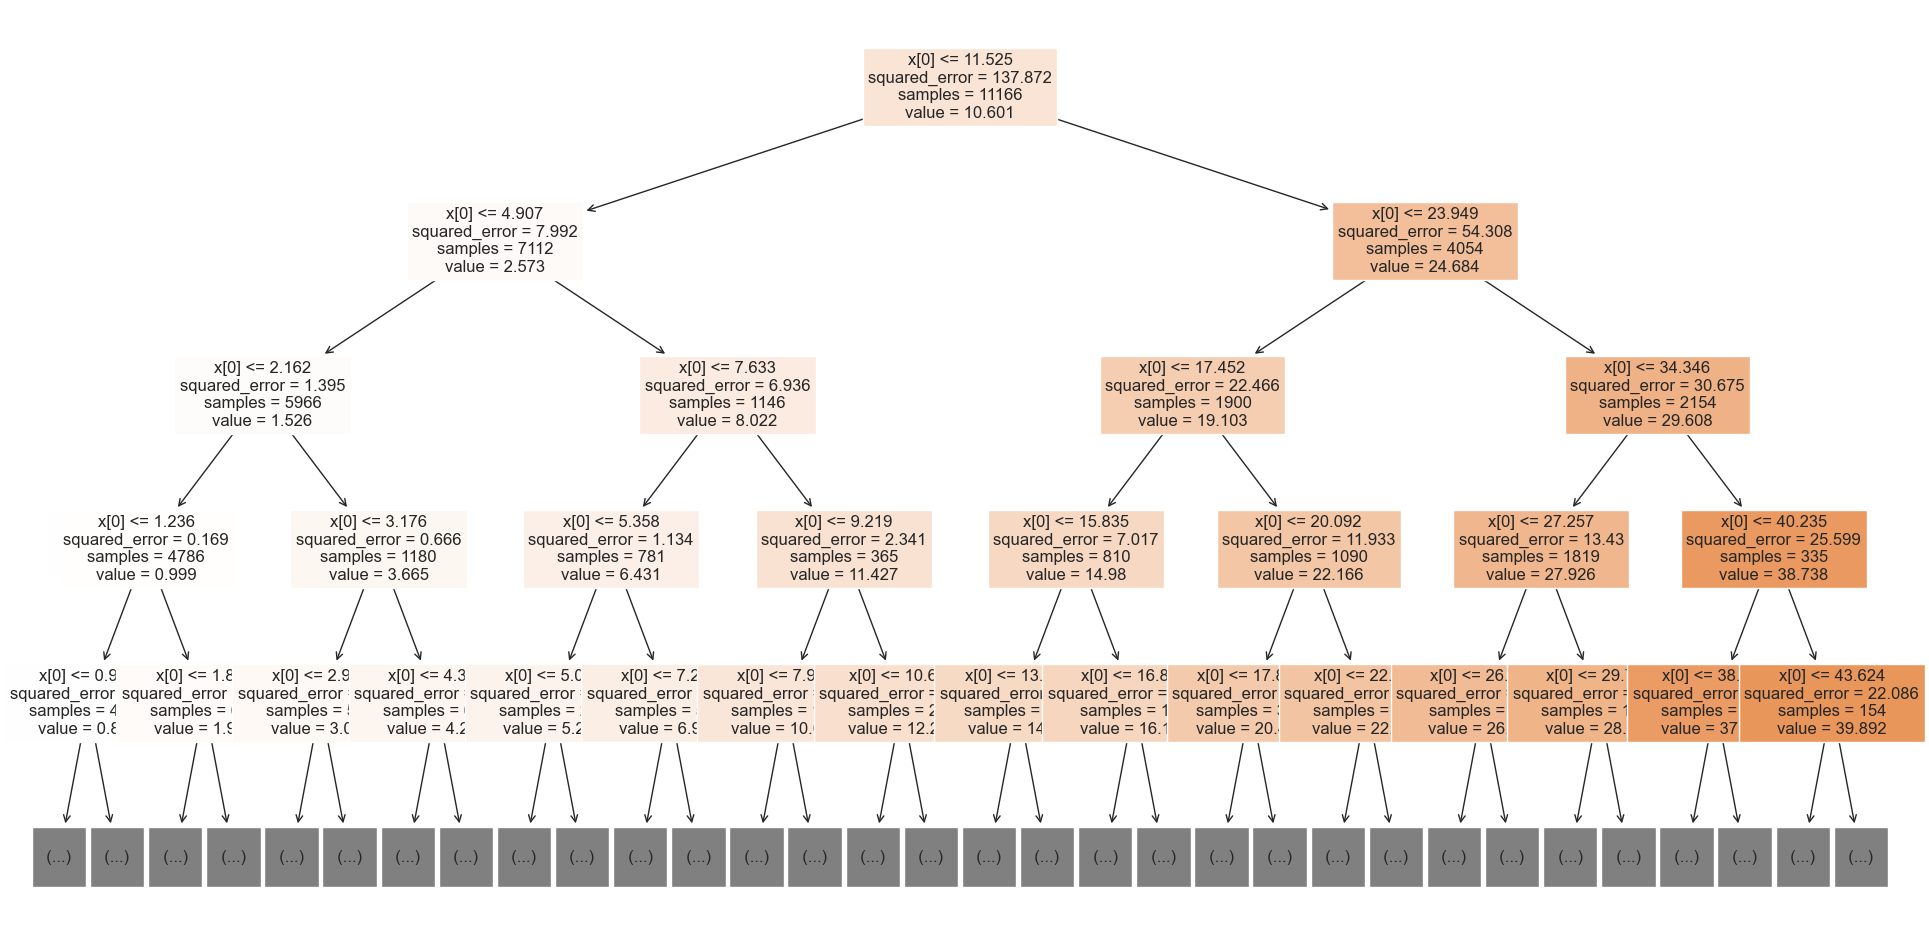

In [7]:
tree = DecisionTreeRegressor().fit(x_train, y_train)

# param_grid = {
#     'max_depth': [100, 150, 200],
#     'min_samples_leaf': [10, 20, 30],
#     'min_samples_split': [2, 4, 6]
# }
#
# grid_search = GridSearchCV(tree, param_grid, scoring='neg_mean_squared_error', cv=3,)
#
# grid_search.fit(x_train, y_train)

tree_prediction = tree.predict(x_future)
print(tree_prediction)

# print(grid_search.best_params_)
# print(grid_search.best_score_)

predictions = tree_prediction
valid = df[X.shape[0]:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title("Model")
plt.xlabel('Days')
plt.ylabel('Close Price USD ($)')
plt.xlim(13925,14060)
plt.ylim(15,38)
plt.plot(df['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(["Original", "Valid", 'Predicted'])
plt.show()

print('MSE = ' + str(mean_squared_error(x_future, tree_prediction)))
# best_dtree = grid_search.best_estimator_

plt.figure(figsize=(24,12))
plot_tree(tree, filled=True, max_depth=4, fontsize=12)

RF

Fitting 3 folds for each of 81 candidates, totalling 243 fits


C:\Users\Admin\AppData\Local\Temp\ipykernel_19224\46724212.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


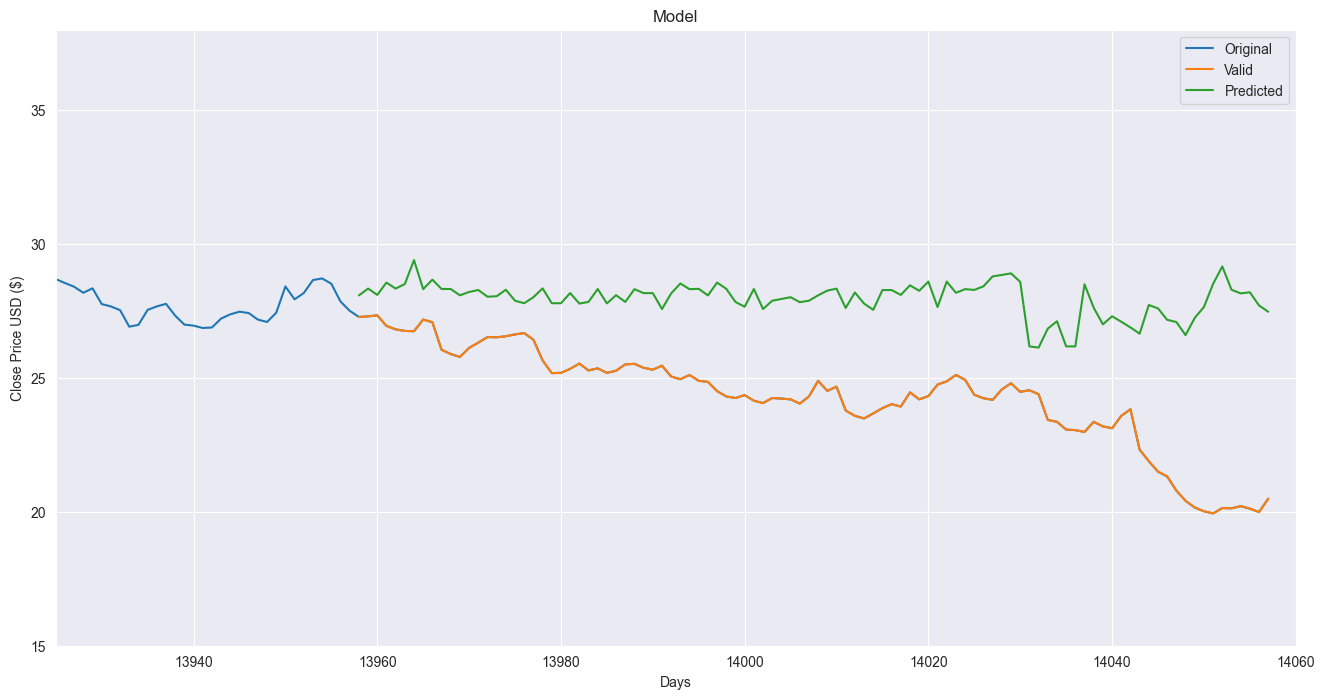

Best Parameters: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best Score: 4.3588442507441
MSE = 16.58171676243056


In [8]:

param_grid = {
    'n_estimators': [100, 200,500],  # Number of trees in the forest
    'max_depth': [ 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'criterion': ['squared_error']  # Splitting criteria
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(x_train, y_train)
rf_prediction = grid_search.predict(x_future)

predictions = rf_prediction
valid = df[X.shape[0]:]
valid['Predictions'] = predictions



plt.figure(figsize=(16,8))
plt.title("Model")
plt.xlabel('Days')
plt.ylabel('Close Price USD ($)')
plt.xlim(13925,14060)
plt.ylim(15,38)
plt.plot(df['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(["Original", "Valid", 'Predicted'])
plt.show()

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

print('MSE = ' + str(mean_squared_error(x_future, tree_prediction)))